In [1]:
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot  
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Reshape
import numpy as np
from numpy.random import randn

import ssl


In [2]:

ssl._create_default_https_context = ssl._create_unverified_context

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU (optional)
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Make only the first GPU visible
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Enable memory growth
        print("GPU is being used")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected")

GPU is being used


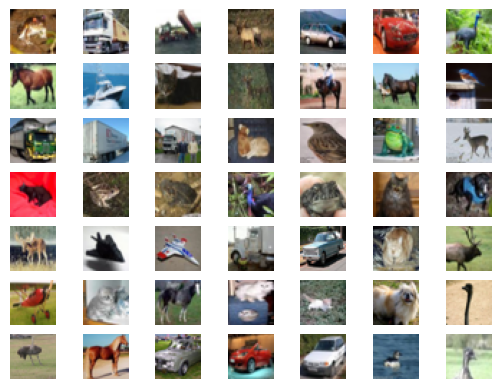

In [3]:
(trainX, trainy), (testX, testy) = load_data()
for i in range(49):
    pyplot.subplot(7, 7, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i])
pyplot.show()

In [4]:
trainX.shape

(50000, 32, 32, 3)

In [5]:
def define_descriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    # Normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.4))  # Fixed the typo from 0,4 to 0.4
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = Adam(learning_rate=0.002, beta_1=0.5)  # Use 'learning_rate' instead of 'lr'
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model  # Return the model object


In [6]:
# Create the model
model = define_descriminator()

# Display model summary and plot
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [7]:
def load_real_sample():
    (trainX, _ ),(_,_)  =load_data()
    X= trainX.astype('float32')
    X= (X-127.5)/127.5
    return X
    

In [8]:
X = load_real_sample()
X.shape

(50000, 32, 32, 3)

In [9]:
X[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

In [10]:
# def generate_real_samples(dataset , n_samples):
#     #choose random instance
#     ix = np.random.randint(0, dataset.shape[0], n_samples)
#     X = dataset[ix]
#     y= np.ones((n_samples, 1))
#     return X,y
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))  # Labels for real samples
    return X, y


In [11]:
X,y=generate_real_samples(X,64)
X.shape

(64, 32, 32, 3)

In [12]:
def generate_fake_samples(n_samples):
    X = np.random.rand(32*32 *3 *n_samples)
    X = -1 +X *2
    X = X.reshape((n_samples, 32, 32, 3))
    y = np.zeros((n_samples,1))
    return X,y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998323755274938..0.9998335162789811].


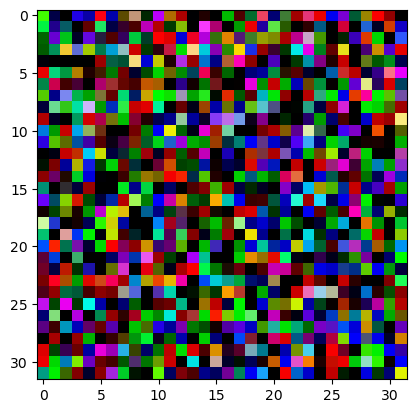

In [13]:
X,y = generate_fake_samples(64)
X.shape
y.shape
# yimsow
pyplot.imshow(X[0])

In [14]:
def train_discriminator(model, dataset , n_iter =20, n_batch =128):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        #get randomly selected 'real samples
        X_real , y_real = generate_real_samples(dataset, half_batch)
        # updates discriminators on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake , y_fake = generate_fake_samples(half_batch)
        #update discrimintors on fake sample
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summerize performance
        print('>%d real = %.0f%% fake = %.0f%%' %(i+1, real_acc*100, fake_acc*100))
        

In [15]:
model = define_descriminator()
dataset = load_real_sample()
train_discriminator(model, dataset)

>1 real = 45% fake = 0%
>2 real = 0% fake = 0%
>3 real = 84% fake = 45%
>4 real = 92% fake = 72%
>5 real = 92% fake = 97%
>6 real = 100% fake = 100%
>7 real = 97% fake = 100%
>8 real = 100% fake = 100%
>9 real = 100% fake = 100%
>10 real = 100% fake = 100%
>11 real = 100% fake = 100%
>12 real = 100% fake = 100%
>13 real = 100% fake = 100%
>14 real = 100% fake = 100%
>15 real = 100% fake = 100%
>16 real = 100% fake = 100%
>17 real = 100% fake = 100%
>18 real = 100% fake = 100%
>19 real = 100% fake = 100%
>20 real = 100% fake = 100%


In [16]:
#define the standalone gnerotor model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 *4 *4
    model.add(Dense(n_nodes, input_dim = latent_dim))
    model.add(LeakyReLU(alpha =0.2))
    model.add(Reshape((4,4,256)))
    #upsample to 8x8
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    #upsample to 16x16
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    #upsample to 32x32
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    # output layer
    model.add(Conv2D(3,(3,3), activation= 'tanh', padding= 'same'))
    return model

In [17]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()
plot_model(model, to_file= 'generator_plot.png', show_shapes=True, show_layer_names= True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)      

In [18]:
def generate_latent_points(latent_dim , n_samples):
    x_input = np.random.rand(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [19]:
x_input = generate_latent_points(100,64)
x_input.shape

(64, 100)

In [20]:
# def generate_fake_sample(g_model, latent_dim, n_samples):
#     x_input = generate_latent_points(latent_dim, n_samples)
#     X= g_model.predict(x_input)
#     y = np.zeros((n_samples,1))
#     return X,y
    
def generate_fake_sample(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1)) 
    return X, y


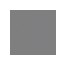

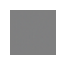

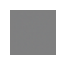

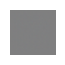

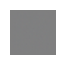

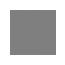

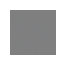

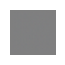

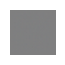

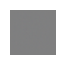

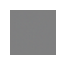

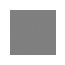

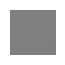

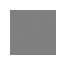

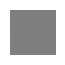

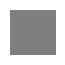

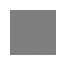

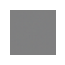

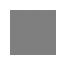

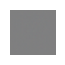

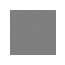

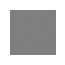

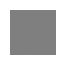

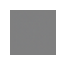

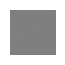

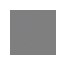

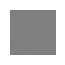

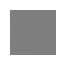

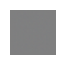

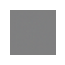

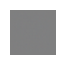

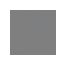

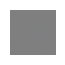

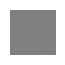

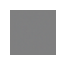

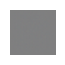

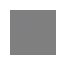

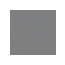

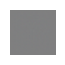

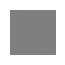

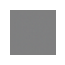

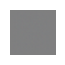

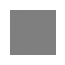

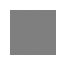

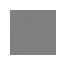

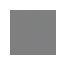

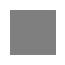

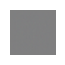

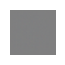

In [21]:
latent_dim =100
model = define_generator(latent_dim)
n_samples = 49
X, _ = generate_fake_sample(model, latent_dim, n_samples)
X= (X+1)/ 2.0
for i in range(n_samples):
    pyplot.subplot(7,7, 1+i)
    pyplot.axis('off')
    pyplot.imshow(X[i])
    pyplot.show()

In [22]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer= opt)
    return model

In [23]:
import torch
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
latent_dim =100
#create the discriminator
d_model = define_descriminator()
#create the generotor
g_model = define_generator(latent_dim)
# create the Gan
gan_model = define_gan(g_model, d_model)
#summery the Gan
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names= True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [25]:
def save_plot(example, epoch, n=7):
    example = (example +1)/2.0
    for i in range(n*n):
        pyplot.subplot(n,n,1 +i)
        pyplot.axis('off')
        pyplot.imshow(example[i])
        filename = 'generated_plot_e%03d.png' %(epoch+1)
        pyplot.savefig(filename)
        pyplot.close()

In [26]:
def summarize_performance(epoch, g_model, dataset, latent_dim, n_sample =150):
    X_real , y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_sample(g_model, latent_dim, n_sample)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' %(acc_real *100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [27]:
# print("X_real shape:", X_real.shape)
# print("Discriminator input shape:", d_model.input_shape)


In [28]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
def train(g_model: Sequential,d_model: Sequential, gan_model: Sequential, dataset, latent_dim, n_epochs=200,n_batch =32):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real , y_real= generate_real_samples(dataset, half_batch)
            # print("X_real shape:", X_real.shape)
            # print("Discriminator input shape:", d_model.input_shape)
            # print("X_real shape:", X_real.shape, "y_real shape:", y_real.shape)
            opt = Adam(learning_rate=0.002, beta_1=0.5)
            d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            #generate fake example
            X_fake, y_fake = generate_fake_sample(g_model, latent_dim, half_batch)
            print("X_fake shape:", X_fake.shape, "y_fake shape:", y_fake.shape)
            #update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            #prepare points in latent space as input for generotor
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake sample
            y_gan = np.ones((n_batch,1))
            # update the generator via the discriminator 's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #summeries the model perfromance, sometimes
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 10==0:
            summarize_performance(i,g_model,dataset,  latent_dim)
        
            


In [ ]:
train(g_model,d_model, gan_model, dataset, latent_dim=100, n_epochs=200,n_batch =32)

X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 1/1562, d1=0.659, d2=0.694 g=0.693
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 2/1562, d1=0.669, d2=0.695 g=0.691
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 3/1562, d1=0.668, d2=0.697 g=0.689
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 4/1562, d1=0.667, d2=0.700 g=0.686
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 5/1562, d1=0.674, d2=0.704 g=0.682
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 6/1562, d1=0.671, d2=0.709 g=0.677
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 7/1562, d1=0.670, d2=0.716 g=0.670
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 8/1562, d1=0.675, d2=0.728 g=0.658
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 9/1562, d1=0.679, d2=0.747 g=0.643
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 10/1562, d1=0.666, d2=0.768 g=0.624
X_fake shape: (16, 32, 32, 3) y_fake shape: (16, 1)
>1, 11/1562, d1=0.669, d2=0.804 g=0.5

In [ ]:
# X_real, y_real = generate_real_samples(dataset, 64)
# d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
# print("Discriminator real loss:", d_loss1, "accuracy:", d_acc1)

# X_fake, y_fake = generate_fake_sample(g_model, latent_dim, 64)
# d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
# print("Discriminator fake loss:", d_loss2, "accuracy:", d_acc2)


In [28]:




def generate_latent_points(latent_dim, n_samples):
    X_input = randn(latent_dim * n_samples)
    X_input = X_input.reshape(n_samples, latent_dim)
    return X_input

def create_plot(example,n):
    for i in range(n*n):
        pyplot.subplot(n,n, 1+i)
        pyplot.axis('off')
        pyplot.imshow(example[i,:,:])
    pyplot.show()
    
model = load_model('generator_model_200.h5')
latent_points = generate_latent_points(100,100)
X = model.predict(latent_points)
X = (X+1)/2.0
create_plot(X,1)
X.shape[0]


NameError: name 'load_model' is not defined

In [ ]:
g_model.save('g_model.keras')
d_model.save('d_model.keras')
gan_model.save('gan_model.keras')